In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/stock_work/chart_model/notebook


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

#### make dataset
- 1回実行したからok

In [2]:
import os
import glob
import pathlib
import shutil
import random
random.seed(42)  # 乱数シード固定

def make_dataset():
    orig_image_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\orig_image'  
    image_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225+日経500'

    paths_1 = glob.glob(os.path.join(orig_image_dir, '1', '*png'))
    paths_0 = glob.glob(os.path.join(orig_image_dir, '0', '*png'))
    # print([pathlib.Path(p).name for p in paths_1[:5]])

    len_paths_1 = len(paths_1)
    len_paths_0 = len(paths_0)
    # print(len_paths_1, len_paths_0)

    # valid, testは各クラス500枚にしておく
    valid_len, test_len = 500, 500
    train_len = len_paths_1 - valid_len - test_len
    # print(train_len, valid_len, test_len)

    # ランダムに並び替え
    paths_1 = random.sample(paths_1, len(paths_1))
    paths_0 = random.sample(paths_0, len(paths_0))
    # print([pathlib.Path(p).name for p in paths_1[:5]])

    # train/vakidation/testに分ける
    train_paths_1 = paths_1[: train_len]
    valid_paths_1 = paths_1[train_len: train_len + valid_len]
    test_paths_1 = paths_1[train_len + valid_len: len_paths_1]
    # print(len(train_paths_1), len(valid_paths_1), len(test_paths_1))
    train_paths_0 = paths_0[: train_len]
    valid_paths_0 = paths_0[train_len: train_len + valid_len]
    test_paths_0 = paths_0[train_len + valid_len: len_paths_1]
    # print(len(train_paths_0), len(valid_paths_0), len(test_paths_0))

    # print([pathlib.Path(p).name for p in paths_1[:5]])
    # print([pathlib.Path(p).name for p in paths_0[:5]])
    
    # train setコピー
    for p in train_paths_1:
        _dir = os.path.join(image_dir, 'train', '1')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
        
    for p in train_paths_0:
        _dir = os.path.join(image_dir, 'train', '0')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
    
    # validation set コピー
    for p in valid_paths_1:
        _dir = os.path.join(image_dir, 'validation', '1')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
        
    for p in valid_paths_0:
        _dir = os.path.join(image_dir, 'validation', '0')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
        
    # test set コピー
    for p in test_paths_1:
        _dir = os.path.join(image_dir, 'test', '1')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
        
    for p in test_paths_0:
        _dir = os.path.join(image_dir, 'test', '0')
        os.makedirs(_dir, exist_ok=True)
        copy = os.path.join(_dir, pathlib.Path(p).name)
        shutil.copyfile(p, copy)
    
# make_dataset()

# multiclass model
- C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py\experiment を基に作成

#### import

In [3]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, util
from model import tf_define_model as define_model
from model import tf_my_callback as my_callback
from model import tf_lr_finder as lr_finder
from model import tf_pooling as pooling
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as base_predict
from predicter import roc_curve, conf_matrix, ensemble_predict

from tensorflow import keras
keras.backend.clear_session()

import glob, time, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

#### parameters

In [4]:
# 出力ディレクトリ
output_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\20200622'

# 入力ディレクトリ
train_data_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225\train'
#train_data_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225+日経500\train'
train_samples = len(util.find_img_files(train_data_dir))

validation_data_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225\validation'
#validation_data_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225+日経500\validation'
val_samples = len(util.find_img_files(validation_data_dir))

test_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225\test'
#test_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\dataset\JPX日経インデックス400+日経225+日経500\test'
test_samples = len(util.find_img_files(test_dir))

gpu_num = 0  # "0,1,2,3"

# 分類クラス
class_name = sorted([str(pathlib.Path(dir_name).name) for dir_name in glob.glob(train_data_dir+'/*')])
classes = class_name
nb_classes = len(classes)

# エポック数、バッチサイズ
num_epoch = 30
batch_size = 50

# 入力層のサイズ
img_rows, img_cols, channels = 150, 150, 3

# finetuning model
choice_model = 'Xception'#'VGG16'#'EfficientNet'#'InceptionV3'
trainable = 'all'  #15#249#'all'
is_skip_bn = True
model_path = None

# 全結合層
fcs = [256]
drop = 0.5
is_add_batchnorm = True#False
l2_rate = 1e-4

# optimizer
choice_optim= 'sgd'
lr = 0.1 * batch_size / 128
lr_factor = 0.01
    
# data augmentation
rescale = 1.0/255.0
#width_shift_range = 0.2
#height_shift_range = 0.2
#horizontal_flip = True
#vertical_flip = True
#shear_range = 20
zoom_range_min = 0.8
zoom_range_max = 1.2
#rotation_range = 20
#channel_shift_range = 5.
#brightness_range_min = 0.3
#brightness_range_max = 1.0
#mix_up_alpha = 0.2# mixup alpha
#random_crop = [img_rows, img_cols]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
#random_erasing_maxpixel = 255
#ricap_beta = 0.3 # RICAP beta
#ricap_use_same_random_value_on_batch = True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
#is_kuzushiji_gen = True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか
#randaugment_N, randaugment_M = 3, 4 # Rand_Augment

In [5]:
# my_IDG_optionsに値詰める。papermillで実行した時でもうまくいくようにする

gpus = str(gpu_num)

if 'zoom_range_min' in list(locals().keys()) and 'zoom_range_max' in list(locals().keys()):
    zoom_range = [zoom_range_min, zoom_range_max]
    
if 'brightness_range_min' in list(locals().keys()) and 'brightness_range_max' in list(locals().keys()):
    brightness_range = [brightness_range_min, brightness_range_max]

my_IDG_options = {}
if 'rescale' in list(locals().keys()):
    my_IDG_options['rescale'] = rescale
        
if 'width_shift_range' in list(locals().keys()):
    my_IDG_options['width_shift_range'] = width_shift_range
    
if 'height_shift_range' in list(locals().keys()):
    my_IDG_options['height_shift_range'] = height_shift_range
    
if 'horizontal_flip' in list(locals().keys()):
    my_IDG_options['horizontal_flip'] = horizontal_flip
    
if 'vertical_flip' in list(locals().keys()):
    my_IDG_options['vertical_flip'] = vertical_flip
    
if 'shear_range' in list(locals().keys()):
    my_IDG_options['shear_range'] = shear_range
    
if 'zoom_range' in list(locals().keys()):
    my_IDG_options['zoom_range'] = zoom_range
    
if 'rotation_range' in list(locals().keys()):
    my_IDG_options['rotation_range'] = rotation_range

if 'channel_shift_range' in list(locals().keys()):
    my_IDG_options['channel_shift_range'] = channel_shift_range

if 'brightness_range' in list(locals().keys()):
    my_IDG_options['brightness_range'] = brightness_range    

if 'mix_up_alpha' in list(locals().keys()):
    my_IDG_options['mix_up_alpha'] = mix_up_alpha
    
if 'random_erasing_prob' in list(locals().keys()):
    my_IDG_options['random_erasing_prob'] = random_erasing_prob
    
if 'random_erasing_maxpixel' in list(locals().keys()):
    my_IDG_options['random_erasing_maxpixel'] = random_erasing_maxpixel

if 'ricap_beta' in list(locals().keys()):
    my_IDG_options['ricap_beta'] = ricap_beta
    
if 'ricap_use_same_random_value_on_batch' in list(locals().keys()):
    my_IDG_options['ricap_use_same_random_value_on_batch'] = ricap_use_same_random_value_on_batch
    
if 'is_kuzushiji_gen' in list(locals().keys()):
    my_IDG_options['is_kuzushiji_gen'] = is_kuzushiji_gen
    
if 'randaugment_N' in list(locals().keys()):
    my_IDG_options['randaugment_N'] = randaugment_N
    
if 'randaugment_M' in list(locals().keys()):
    my_IDG_options['randaugment_M'] = randaugment_M

#### data generator

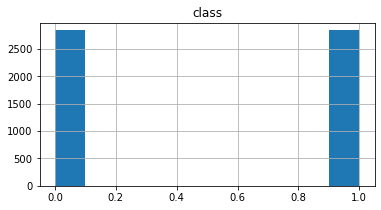

interactive(children=(IntSlider(value=2831, description='index', max=5663), Output()), _dom_classes=('widget-i…

In [6]:
# train setの分布と元画像をipywidgetsで表示

train_img_paths = util.find_img_files(train_data_dir)
train_img_class = [pathlib.Path(p).parent.stem for p in train_img_paths]
df_train_path = pd.DataFrame({'class':train_img_class, 'path':train_img_paths})

df_train_path['class'] = df_train_path['class'].astype(int)

df_train_path[['class']].hist(figsize = (6, 3))
util.ipywidgets_show_img(df_train_path['path'], figsize=(6, 6))

In [7]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    #print(f"y:\n{y}")
    print(f"y[0]: {y[0]}")
    util.plot_5imgs(x)
    return x,y

In [10]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size, valid_batch_size=batch_size, test_batch_size=batch_size
                                            , train_samples=train_samples, valid_samples=val_samples, test_samples=test_samples)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

train_steps_per_epoch : 113
valid_steps_per_epoch : 20
test_steps_per_epoch : 1
my_IDG_options: {'rescale': 0.00392156862745098, 'zoom_range': [0.8, 1.2], 'random_erasing_prob': 0.5}
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x0000017C6C3F5BC8>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x17adbee2f88>)

Found 5664 images belonging to 2 classes.
x.shape: (50, 150, 150, 3)
y.shape: (50, 2)
y[0]: [0. 1.]
Num_Images:  50


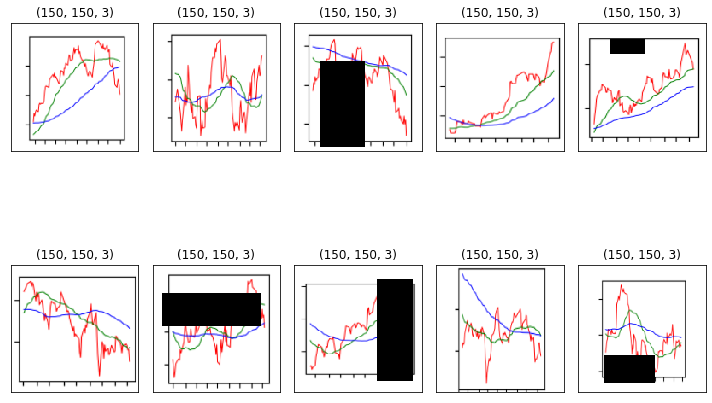

<Figure size 432x288 with 0 Axes>

In [9]:
x,y = check_gen(d_cls.train_gen)

x.shape: (50, 150, 150, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


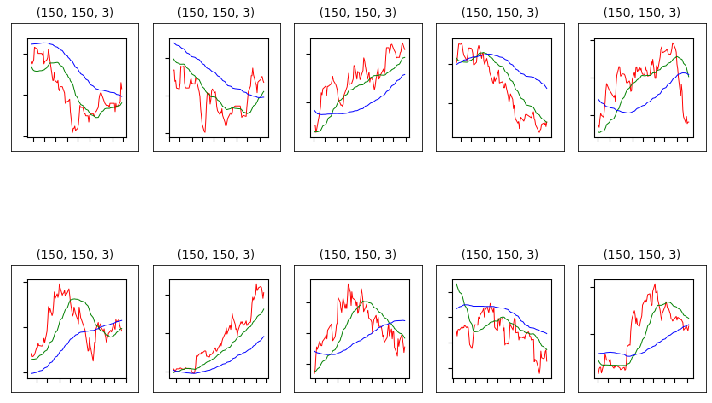

<Figure size 432x288 with 0 Axes>

In [10]:
x,y = check_gen(d_cls.valid_gen)

x.shape: (50, 150, 150, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


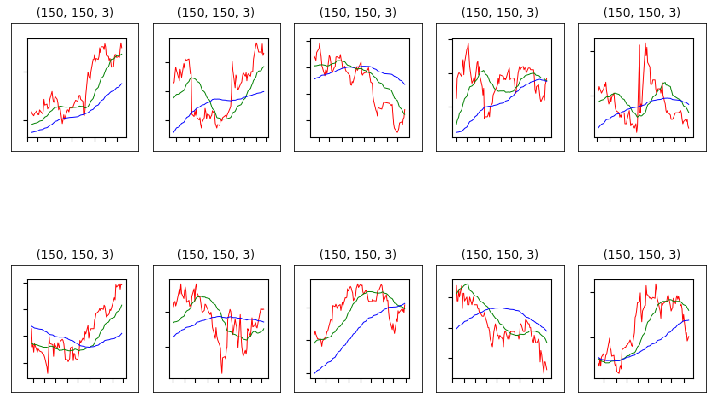

<Figure size 432x288 with 0 Axes>

In [11]:
x,y = check_gen(d_cls.test_gen)

#### model

In [7]:
# loss
loss = 'categorical_crossentropy'
metrics = ['accuracy']
activation = 'softmax'

# model
if model_path is None:
    if trainable != 'all':
        trainable = int(trainable)
    model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                           , len(classes)
                                                           , choice_model, trainable
                                                           , fcs=fcs, drop=drop
                                                           , is_add_batchnorm=is_add_batchnorm
                                                           , l2_rate=l2_rate
                                                           , activation=activation
                                                           , gpu_count=len(gpus.split(','))
                                                           , skip_bn=is_skip_bn
                                                          )
    
else:
    model = keras.models.load_model(model_path, compile=False)
    
optim = define_model.get_optimizers(choice_optim, lr=lr)
model.compile(loss=loss, optimizer=optim, metrics=metrics)

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True


In [11]:
define_model.print_model_summary(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [12]:
# 最適な学習率探索. 後続処理実行する場合はデータとモデル再定義必要
#lr_finder.run(model, d_cls.train_gen, batch_size, d_cls.init_train_steps_per_epoch, output_dir=output_dir)

#### train

In [8]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(factor=lr_factor, epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_loss_best.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_accuracy_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//2, verbose=1))
    return cb

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30
112/113 [============================>.] - ETA: 0s - loss: 0.7452 - accuracy: 0.5021
Epoch 00001: val_loss improved from inf to 0.74518, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\val_accuracy_best.h5
113/113 [==============================] - 39s 349ms/step - loss: 0.7452 - accuracy: 0.5021 - val_loss: 0.7452 - val_accuracy: 0.5000
Epoch 2/30
112/113 [============================>.] - ETA: 0s - loss: 0.7417 - accuracy: 0.5182
Epoch 00002: val_loss improved from 0.74518 to 0.74182, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\val_loss_best.h5

Epoch 00002: val_accuracy improved from 0.50000 to 0.51500, saving model to C

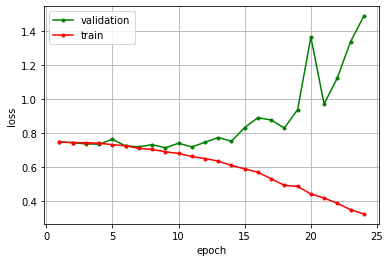

<Figure size 432x288 with 0 Axes>

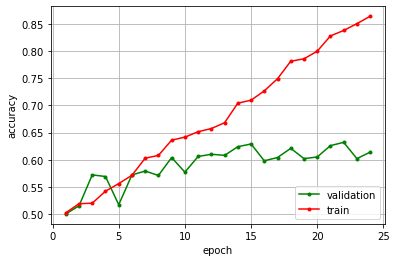

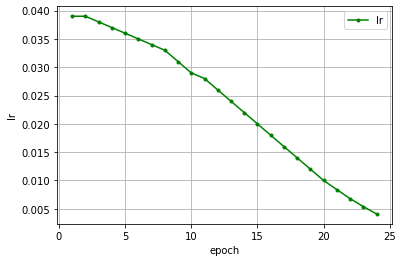

<Figure size 432x288 with 0 Axes>

In [27]:
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = train_samples//batch_size
    , epochs = num_epoch
    , validation_data = d_cls.valid_gen
    , validation_steps = val_samples//batch_size
    , verbose = 1 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, num_epoch)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'), acc_metric=metrics[0])

#### predict

Instructions for updating:
Please use Model.predict, which supports generators.


,Filename,PredictionLabel,PredictionScore
0,0\1332_2005-03-05_2005-07-09.png,1,0.85
1,0\1332_2005-07-09_2005-11-12.png,1,0.77
2,0\1801_2001-09-22_2002-01-26.png,1,0.552
3,0\1801_2004-10-30_2005-03-05.png,1,0.574
4,0\1801_2011-01-15_2011-05-21.png,0,0.639


y_pred_list_str: ['1' '1' '1' '1' '0' '1' '0' '1' '1' '0' '1' '1' '1' '0' '0' '0' '1' '1'
 '1' '0' '0' '1' '1' '1' '0' '1' '0' '1' '0' '1' '0' '0' '0' '1' '0' '0'
 '1' '0' '0' '1' '0' '0' '1' '1' '1' '1' '1' '1' '0' '1' '1' '0' '1' '0'
 '0' '0' '0' '1' '0' '1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1'
 '0' '1' '1' '0' '1' '1' '0' '1' '1' '1' '0' '1' '1' '0' '0' '1' '0' '0'
 '1' '0' '1' '0' '0' '0' '1' '0' '1' '1' '0' '1' '0' '1' '1' '1' '0' '1'
 '0' '0' '0' '0' '1' '0' '0' '1' '1' '1' '0' '0' '0' '1' '0' '0' '0' '1'
 '0' '1' '1' '0' '1' '1' '0' '0' '1' '1' '0' '0' '0' '0' '0' '0' '1' '1'
 '1' '1' '1' '0' '0' '1' '1' '1' '0' '0' '0' '1' '0' '0' '0' '0' '1' '0'
 '0' '0' '1' '0' '1' '1' '1' '1' '1' '0' '1' '0' '1' '1' '0' '1' '0' '0'
 '0' '0' '1' '1' '0' '1' '0' '1' '0' '1' '0' '1' '1' '1' '0' '0' '1' '0'
 '1' '0' '0' '1' '1' '0' '1' '1' '1' '1' '0' '0' '0' '1' '1' '0' '1' '1'
 '0' '1' '0' '1' '0' '1' '1' '1' '1' '0' '0' '0' '1' '1' '1' '1' '1' '1'
 '1' '0' '0' '1' '1' '0' '1' '1' '

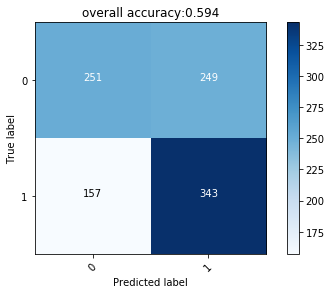

<Figure size 432x288 with 0 Axes>

In [15]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))
                                     #, custom_objects={'BlurPooling2D':pooling.BlurPooling2D
                                     #                  , 'GeM2D':pooling.GeM2D})
#load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
display(pred_df.head())

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

#### Grad-CAM

In [16]:
out_grad_cam_dir = os.path.join(output_dir, 'grad_cam/test')
os.makedirs(out_grad_cam_dir, exist_ok=True)

for i,p in tqdm(enumerate(util.find_img_files(test_dir))):
                
    # 10枚ごとにモデル再ロード
    if i % 10 == 0:
        keras.backend.clear_session() # セッションのクリア
        keras.backend.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる
        model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))
                                        #, custom_objects={'BlurPooling2D':pooling.BlurPooling2D
                                        #                  , 'GeM2D':pooling.GeM2D})
        #model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False) # モデルロード
    
    grad_cam_img = grad_cam.image2gradcam(model, p, out_dir=out_grad_cam_dir)
    
    if i == 30:
        break

out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1332_2005-03-05_2005-07-09_classidx1_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1332_2005-07-09_2005-11-12_classidx1_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1801_2001-09-22_2002-01-26_classidx1_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1801_2004-10-30_2005-03-05_classidx1_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1801_2011-01-15_2011-05-21_classidx0_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test/1802_2010-09-11_2011-01-15_classidx1_gradcam.jpg
out_jpg: C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\grad_cam/test

Num_Images:  36


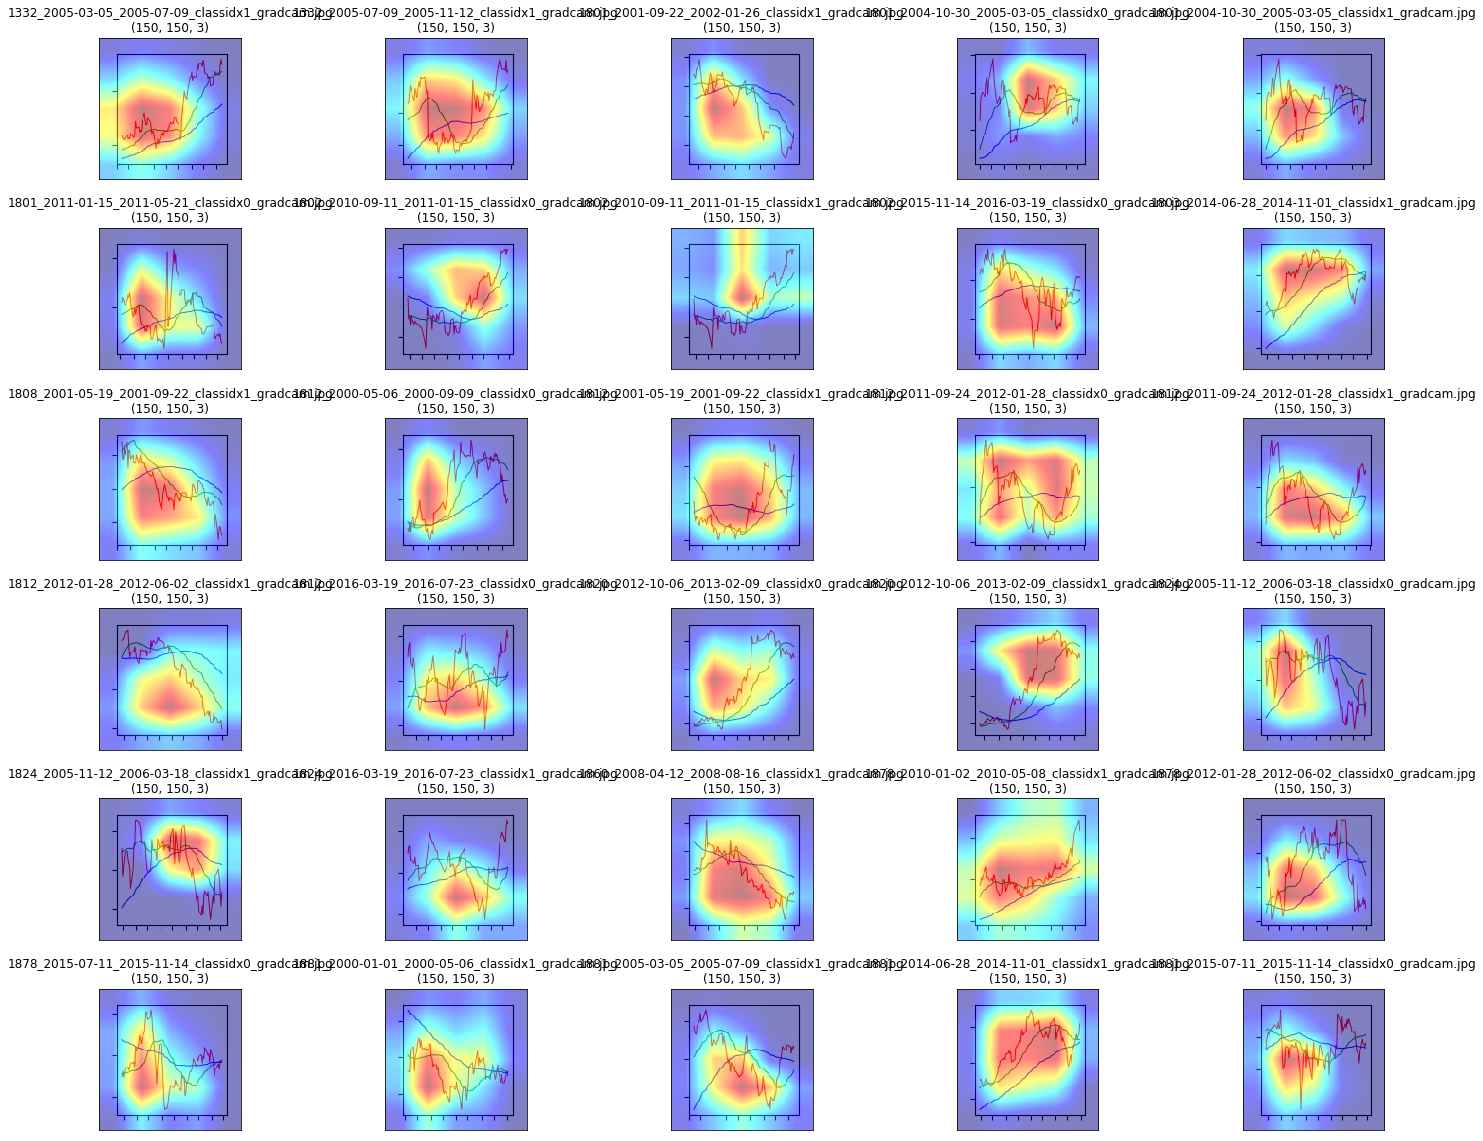

<Figure size 432x288 with 0 Axes>

In [17]:
img_list = glob.glob(out_grad_cam_dir+'/*.jpg')
num = 30
util.plot_5imgs(img_list
                , plot_num=num
                , figsize=(10*2, 8*2)
                , labels=[str(pathlib.Path(p).name) for p in img_list[:num]])

## optuna

In [11]:
import optuna
import traceback

output_dir = r'C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna'

class Objective(object):

    def trial_train(self, trial):
        """ Train function for optuna """
        ## Hyper parameter setting
        choice_model = trial.suggest_categorical('choice_model', ['VGG16', 'Inceptionv3', 'Xception', 'NASNetLarge', 'EfficientNet']) # リストから選択
        efficientnet_num = trial.suggest_categorical('efficientnet_num', [3, 4, 5, 6, 7]) # リストから選択
        trainable = 'all'
        
        """ モデルの学習 """
        keras.backend.clear_session()
        if trainable != 'all':
            trainable = int(trainable)
        model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                               , len(classes)
                                                               , choice_model, trainable
                                                               , fcs=fcs, drop=drop
                                                               , is_add_batchnorm=is_add_batchnorm
                                                               , l2_rate=l2_rate
                                                               , activation=activation
                                                               , gpu_count=len(gpus.split(','))
                                                               , skip_bn=is_skip_bn
                                                               , efficientnet_num=efficientnet_num
                                                              )
        optim = define_model.get_optimizers(choice_optim, lr=lr)
        model.compile(loss=loss, optimizer=optim, metrics=metrics)
        history = model.fit_generator(
            d_cls.train_gen
            , steps_per_epoch = train_samples//batch_size
            , epochs = num_epoch
            , validation_data = d_cls.valid_gen
            , validation_steps = val_samples//batch_size
            , verbose = 2 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
            , callbacks = get_cb(output_dir, num_epoch)
            )
        return np.min(history.history['val_loss']) # Minimize metrics.

    def __call__(self, trial):
        """ Objective function for optuna """
        try: # optuna v0.18以上だとtryで囲まないとエラーでtrial落ちる
            min_eval_metric= self.trial_train(trial)
            return min_eval_metric
        except Exception as e:
            traceback.print_exc() # Exceptionが発生した際に表示される全スタックトレース表示
            return e # 例外を返さないとstudy.csvにエラー内容が記載されない

        
if __name__ == '__main__':
    study_name = 'study'  # Unique identifier of the study.
    sqllite_path = os.path.join(output_dir, 'study.db')
    study = optuna.create_study(study_name=study_name, storage=f"sqlite:///{sqllite_path}", load_if_exists=True)
    study.optimize(Objective(), n_trials=30)
    study.trials_dataframe().to_csv(os.path.join(output_dir, f"{study_name}_history.csv"), index=False)
    print(f"\nstudy.best_params:\n{study.best_params}")
    print(f"\nstudy.best_trial:\n{study.best_trial}")

[I 2020-06-23 03:56:21,631] Using an existing study with name 'study' instead of creating a new one.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
Instructions for updating:
Please use Model.fit, which supports generators.
Found 5664 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74421, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_acc

[I 2020-06-23 04:14:04,698] Finished trial#9 resulted in value: 0.6904284179210662. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74230, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50900, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\

[I 2020-06-23 04:26:57,139] Finished trial#10 resulted in value: 0.7043345332145691. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
152608768/343610240 [============>.................] - ETA:  - ETA: 43:3 - ETA: 37:2 - ETA: 26:2 - ETA: 23:0 - ETA: 15:4 - ETA: 14:0 - ETA: 9:4 - ETA: 9: - ETA: 7: - ETA: 7: - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA:

Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss did not improve from inf

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_accuracy_best.h5
113/113 - 35s - loss: nan - accuracy: 0.4986 - val_loss: nan - val_accuracy: 0.5000
E

[W 2020-06-23 04:38:32,187] Setting status of trial#12 as TrialState.FAIL because the objective function returned nan.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Inceptionv3 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 28, in trial_train
    , efficientnet_num=efficientnet_num
  File "C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\tf_define_model.py", line 791, in get_fine_tuning_model
    x = trained_model.output
UnboundLocalError: local variable 'trained_model' referenced before assignment
[W 2020-06-23 04:38:32,576] Setting status of trial#13 as TrialState.FAIL because the returned value from the objective function cannot be casted to float. Returned value is: UnboundLocalError("local variable 'trained_model' referenced before assignment")


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB4
input_shape: (150, 150, 3)
71892992/71892840 [==============================] - ETA: 25:3 - ETA: 10:1 - ETA: 5:5 - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 40s - ETA: 31 - ETA: 34 - ETA: 37 - ETA: 36 - ETA: 37 - ETA: 38 - ETA: 39 - ETA: 41 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 33 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 

Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74463, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\out

[I 2020-06-23 04:53:48,225] Finished trial#15 resulted in value: 0.7325650751590729. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB5
input_shape: (150, 150, 3)
115515392/115515256 [==============================] - ETA: 33:1 - ETA: 15:2 - ETA: 9:0 - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 5

Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB5
input_shape: (150, 150, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss did not improve from inf

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_accuracy_best.h5
113/113 - 29s - loss: nan - accuracy: 0.4984 - val_loss: nan - val_accuracy: 0.5000
E

[W 2020-06-23 05:06:42,955] Setting status of trial#19 as TrialState.FAIL because the objective function returned nan.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74410, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\

[I 2020-06-23 05:24:02,435] Finished trial#21 resulted in value: 0.7154707133769989. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Inceptionv3 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 28, in trial_train
    , efficientnet_num=efficientnet_num
  File "C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\tf_define_model.py", line 791, in get_fine_tuning_model
    x = trained_model.output
UnboundLocalError: local variable 'trained_model' referenced before assignment
[W 2020-06-23 05:24:03,081] Setting status of trial#22 as TrialState.FAIL because the returned value from the objective function cannot be casted to float. Returned value is: UnboundLocalError("local variable 'trained_model' referenced before assignment")


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74244, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.53500, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\

[I 2020-06-23 05:35:48,790] Finished trial#23 resulted in value: 0.726033179461956. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB5
input_shape: (150, 150, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74417, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\out

[I 2020-06-23 05:50:56,254] Finished trial#25 resulted in value: 0.7328922152519226. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB6
input_shape: (150, 150, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB4
input_shape: (150, 150, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss did not improve from inf

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_accuracy_best.h5
113/113 - 30s - loss: nan - accuracy: 0.4950 - val_loss: nan - val_accuracy: 0.5000
E

[W 2020-06-23 06:10:33,329] Setting status of trial#31 as TrialState.FAIL because the objective function returned nan.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = NASNetLarge all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB4
input_shape: (150, 150, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = EfficientNet all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB7
input_shape: (150, 150, 3)
165511168/258434480 [==================>...........] - ETA: 49:1 - ETA: 31:3 - ETA: 32:2 - ETA: 19:1 - ETA: 11:1 - ETA: 6:5 - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - 

Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 39, in trial_train
    , callbacks = get_cb(output_dir, num_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core

----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Xception all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74037, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50300, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\

[I 2020-06-23 06:30:43,167] Finished trial#36 resulted in value: 0.7080698907375336. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = VGG16 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 20 steps
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.74578, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\out

Epoch 23/30

Epoch 00023: val_loss improved from 0.73321 to 0.73314, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00023: val_accuracy did not improve from 0.50000
113/113 - 28s - loss: 0.7334 - accuracy: 0.4977 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 24/30

Epoch 00024: val_loss improved from 0.73314 to 0.73303, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00024: val_accuracy did not improve from 0.50000
113/113 - 28s - loss: 0.7332 - accuracy: 0.5011 - val_loss: 0.7330 - val_accuracy: 0.5000
Epoch 25/30

Epoch 00025: val_loss improved from 0.73303 to 0.73299, saving model to C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna\val_loss_best.h5

Epoch 00025: val_accuracy did not improve from 0.50000
113/113 - 28s - loss: 0.7331 - accuracy: 0.4964 - val_loss: 0.7330 - val_accuracy: 0.5000
E

[I 2020-06-23 06:44:52,020] Finished trial#37 resulted in value: 0.7328835129737854. Current best value is 0.6904284179210662 with parameters: {'choice_model': 'Xception', 'efficientnet_num': 7}.


----- model_param -----
output_dir = C:\Users\81908\jupyter_notebook\tf_2_work\stock_work\chart_model\output\model\optuna
img_rows img_cols channels = 150 150 3
num_classes = 2
choice_model trainable = Inceptionv3 all
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1


Traceback (most recent call last):
  File "<ipython-input-11-a68a3027e70c>", line 46, in __call__
    min_eval_metric= self.trial_train(trial)
  File "<ipython-input-11-a68a3027e70c>", line 28, in trial_train
    , efficientnet_num=efficientnet_num
  File "C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\tf_define_model.py", line 791, in get_fine_tuning_model
    x = trained_model.output
UnboundLocalError: local variable 'trained_model' referenced before assignment
[W 2020-06-23 06:44:52,501] Setting status of trial#38 as TrialState.FAIL because the returned value from the objective function cannot be casted to float. Returned value is: UnboundLocalError("local variable 'trained_model' referenced before assignment")



study.best_params:
{'choice_model': 'Xception', 'efficientnet_num': 7}

study.best_trial:
FrozenTrial(number=9, state=TrialState.COMPLETE, value=0.6904284179210662, datetime_start=datetime.datetime(2020, 6, 23, 3, 56, 21, 639915), datetime_complete=datetime.datetime(2020, 6, 23, 4, 14, 4, 663120), params={'choice_model': 'Xception', 'efficientnet_num': 7}, distributions={'choice_model': CategoricalDistribution(choices=('VGG16', 'Inceptionv3', 'Xception', 'NASNetLarge', 'EfficientNet')), 'efficientnet_num': CategoricalDistribution(choices=(3, 4, 5, 6, 7))}, user_attrs={}, system_attrs={'_number': 9}, intermediate_values={}, trial_id=10)
